bluestore_lat_simple 0.087308 , simple_start 2020-05-17T19:25:08.848555-0500
bluestore_lat_simple 0.087312 , simple_start 2020-05-17T19:25:08.848568-0500
bluestore_lat_simple 0.087384 , simple_start 2020-05-17T19:25:08.848583-0500
bluestore_lat_simple 0.097581 , simple_start 2020-05-17T19:25:08.848585-0500
bluestore_lat_simple 0.097617 , simple_start 2020-05-17T19:25:08.848599-0500
bluestore_lat_simple 0.097617 , simple_start 2020-05-17T19:25:08.848605-0500
bluestore_lat_simple 0.09764 , simple_start 2020-05-17T19:25:08.848642-0500
bluestore_lat_simple 0.097625 , simple_start 2020-05-17T19:25:08.848674-0500
bluestore_lat_simple 0.097599 , simple_start 2020-05-17T19:25:08.848706-0500
bluestore_lat_simple 0.097501 , simple_start 2020-05-17T19:25:08.848809-0500
bluestore_lat_simple 0.097502 , simple_start 2020-05-17T19:25:08.848818-0500
bluestore_lat_simple 0.097518 , simple_start 2020-05-17T19:25:08.848813-0500
bluestore_lat_simple 0.097478 , simple_start 2020-05-17T19:25:08.848863-0500


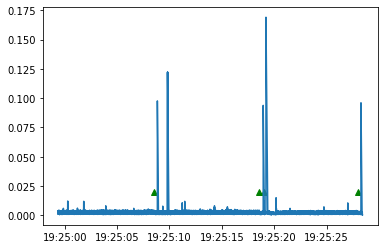

't1 = parser.parse(check_bracket(data1.values[0,3])).replace(tzinfo=utc)\nt2 = (parser.parse(id2.values[0,1])-timedelta(hours=5)).replace(tzinfo=utc)\nprint(parser.parse(check_bracket(data1.values[0,3])).replace(tzinfo=utc))\nprint((parser.parse(id2.values[0,1])-timedelta(hours=5)))\nprint(t2-t1)'

In [24]:
import sys
import numpy as np
from pandas import read_csv
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt

utc=pytz.UTC # work with offset-naive and offset-aware datetimes

f1='dump_time_stamps_vec.csv'
data1=read_csv(f1, skiprows=10000, parse_dates=True, squeeze=True, sep=',', header=None)
datalen = len(data1.values)

def check_bracket(str):
    if str == None:
        return "0"
    if str.startswith('['):
        return str[1:]
    if str.endswith(']'):
        return str[:-1]
    return str

# for bluestore latency
x_bs_lat = []
y_bs_lat = []


# process the time stamps
for i in range(datalen-1):
    # simple writes
    #if len(data1.values[i,:]) == len(data1.values[i+1,:]) and data1.values[i,2] == 'simple_s':
    if data1.values[i,2] == 'simple_s':
        # for first ctx
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        simple_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        aio_done1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        simple_e1 = parser.parse(check_bracket(data1.values[i,11])).replace(tzinfo=utc)
        # for second ctx
        '''ctr_ctx2 = parser.parse(check_bracket(data1.values[i+1,1]))
        simple_s2 = parser.parse(check_bracket(data1.values[i+1,3]))
        aio_done2 = parser.parse(check_bracket(data1.values[i+1,5]))
        flush_cmt_s2 = parser.parse(check_bracket(data1.values[i+1,7]))
        flush_cmt_e2 = parser.parse(check_bracket(data1.values[i+1,9]))
        simple_e2 = parser.parse(check_bracket(data1.values[i+1,11]))'''
        # sanity check of timestamps
        if simple_s1 < ctr_ctx1 or aio_done1 < simple_s1 or flush_cmt_s1 < aio_done1 or flush_cmt_e1 < flush_cmt_s1 or simple_e1 < flush_cmt_e1:
            print("simple writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_simple = simple_e1 - simple_s1
        x_bs_lat.append(simple_s1)
        y_bs_lat.append(bluestore_lat_simple.total_seconds())
        
        # spikes
        if bluestore_lat_simple.total_seconds() > 0.05:
            print("bluestore_lat_simple",bluestore_lat_simple.total_seconds(),", simple_start",check_bracket(data1.values[i,3]))

    # deferred writes
    elif data1.values[i,2] == 'deferred_s':
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        deferred_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        deferred_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        # sanity check of timestamps
        if deferred_s1 < ctr_ctx1 or flush_cmt_s1 < deferred_s1 or flush_cmt_e1 < flush_cmt_s1 or deferred_e1 < flush_cmt_e1:
            print("deferred writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_deferred = deferred_e1 - deferred_s1
        x_bs_lat.append(deferred_s1)
        y_bs_lat.append(bluestore_lat_deferred.total_seconds())
        
        # spikes
        if bluestore_lat_deferred.total_seconds() > 0.05:
            print("bluestore_lat_deferred",bluestore_lat_deferred.total_seconds(),", deferred_start",check_bracket(data1.values[i,3]))

#if1='l0recover_job_timestamps.csv' # Compaction for recovery writes. Happens before fio 
if2='flush_job_timestamps.csv'     # Compaction for L0
if3='compact_job_timestamps.csv'   # Compaction for other levels
#id1=read_csv(if1, parse_dates=True, squeeze=True, sep=',', header=None)
id2=read_csv(if2, parse_dates=True, squeeze=True, sep=',', header=None)
id3=read_csv(if3, parse_dates=True, squeeze=True, sep=',', header=None)

#id1len = len(id1.values)
id2len = len(id2.values)
id3len = len(id3.values)

x_compact = [] # timestamps
y_compact = [] # dummp y value
w_compact = [] # durations(width of compaction)
#for i in range(id1len):
#    x_compact.append(parser.parse(id1.values[i,1])-timedelta(hours=5)) # there is a 5hrs difference with ceph_clock_now()
#    w_compact.append(id1.values[i,5]/1000000)
#    y_compact.append(0.02)
for i in range(id2len):
    x_compact.append((parser.parse(id2.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w_compact.append(id2.values[i,5]/1000000)
    y_compact.append(0.02)
for i in range(id3len):
    x_compact.append((parser.parse(id3.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    w_compact.append(id3.values[i,5]/1000000)
    y_compact.append(0.02)

# plot
#fig, ax = plt.subplots()
plt.plot(x_compact, y_compact, label='compact',marker='^', c='g', linestyle='')
#ax.set(xlabel='time stamps', ylabel='latency [secs]', title='Compaction Latency Time Series')            
           
plt.plot(x_bs_lat, y_bs_lat, label='bluestore')
#ax.set(xlabel='time stamps', ylabel='latency [secs]', title='BlueStore Latency Time Series')
#plt.legend()
plt.show()
plt.close()

'''t1 = parser.parse(check_bracket(data1.values[0,3])).replace(tzinfo=utc)
t2 = (parser.parse(id2.values[0,1])-timedelta(hours=5)).replace(tzinfo=utc)
print(parser.parse(check_bracket(data1.values[0,3])).replace(tzinfo=utc))
print((parser.parse(id2.values[0,1])-timedelta(hours=5)))
print(t2-t1)'''